In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:.3f}'.format

### Path Settings

In [2]:
data_dir = Path('../CUD/')
feature_dir = Path('../CUD/feature')

data = feature_dir / 'BTCUSDT 15 Aug, 2017 31 Aug, 2021.csv'
btc = pd.read_csv(data)

In [3]:
btc

,Open time,Open,High,Low,Close,Volume,Quote asset volume,Num trades,VWAP,RSI
0,Thu Aug 17 13:00:00 2017,4261.480,4349.990,4261.320,4349.990,82.089,353194.333,334.000,4320.433,NaN
1,Thu Aug 17 17:00:00 2017,4333.320,4485.390,4333.320,4427.300,63.620,282501.158,248.000,4361.870,NaN
2,Thu Aug 17 21:00:00 2017,4436.060,4485.390,4333.420,4352.340,174.562,774238.798,858.000,4377.411,NaN
3,Fri Aug 18 01:00:00 2017,4352.330,4354.840,4200.740,4325.230,225.110,965291.099,986.000,4342.819,NaN
4,Fri Aug 18 05:00:00 2017,4307.560,4369.690,4258.560,4285.080,249.770,1079544.663,1001.000,4330.765,NaN
...,...,...,...,...,...,...,...,...,...,...
8828,Mon Aug 30 17:00:00 2021,47933.160,48200.000,47620.050,47902.760,4820.492,231022626.296,157091.000,18212.911,37.117
8829,Mon Aug 30 21:00:00 2021,47902.760,48089.300,47370.000,48019.640,7559.228,360816872.183,237657.000,18215.904,37.454
8830,Tue Aug 31 01:00:00 2021,48012.780,48620.000,47956.630,48619.990,6266.590,302480334.767,172274.000,18218.432,49.321
8831,Tue Aug 31 05:00:00 2021,48619.990,48696.870,46853.000,46982.910,9441.871,450773559.965,237968.000,18222.129,33.481


In [4]:
btc['Open time'] = pd.to_datetime(btc['Open time'])
btc.index = btc['Open time']
btc = btc.drop(['Open time'], axis=1)

In [5]:
btc.interpolate(method = 'linear', axis=1, inplace=True)

In [6]:
train = btc.iloc[:-84]
test = btc.iloc[-84:]
print(train.shape,test.shape)

(8749, 9) (84, 9)


### Augmented Dickey Fuller(ADF)

In [7]:
def adf_test(timeseries):
    #ADF:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

for c in btc.columns:  
    print(f'=========={c}==========')
    adf_test(btc[c])

==========Open==========
Results of Dickey-Fuller Test:
Test Statistic                  -0.343
p-value                          0.919
#Lags Used                      35.000
Number of Observations Used   8797.000
Critical Value (1%)             -3.431
Critical Value (5%)             -2.862
Critical Value (10%)            -2.567
dtype: float64
==========High==========
Results of Dickey-Fuller Test:
Test Statistic                  -0.443
p-value                          0.903
#Lags Used                      36.000
Number of Observations Used   8796.000
Critical Value (1%)             -3.431
Critical Value (5%)             -2.862
Critical Value (10%)            -2.567
dtype: float64
==========Low==========
Results of Dickey-Fuller Test:
Test Statistic                  -0.335
p-value                          0.920
#Lags Used                      37.000
Number of Observations Used   8795.000
Critical Value (1%)             -3.431
Critical Value (5%)             -2.862
Critical Value (10%)   

### Vetor Auto Regression (VAR)

In [8]:
var_model = VAR(endog=train)
var_model_fit = var_model.fit()

# make prediction on validation
prediction = var_model_fit.forecast(var_model_fit.y, steps=len(test))

In [9]:
predict_df = pd.DataFrame(prediction)
predict_df.columns = btc.columns

In [10]:
predict_df.index = test.index

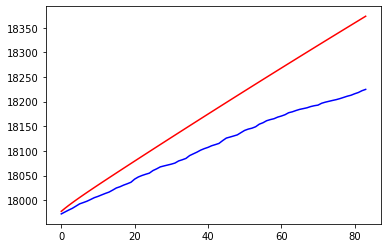

In [11]:
plt.plot(test.VWAP.values,'b')
plt.plot(predict_df.VWAP.values,'r')
plt.show()